In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2, pool2graph_BootstrapInit, pool2graph_RandomSplit

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
### Get data and fit a pool of classifiers on it

#X_train, X_test, yLe_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat', test_size=0.33, RANDOM_STATE=None)

print(X_train.shape, y_train.mean())
cont_names = list(set(feature_names) - set(cat_names))

taking only 3000 instances
(2010, 96) 0.25024875621890547


[15:27:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracies (F1):  {'RF200': 0.6512820512820513, 'XGB': 0.6879271070615034, 'LR': 0.6474820143884892, 'GB': 0.6792452830188679}
Discrepancies on train: 0.15323383084577114
Discrepancies on test: 0.1383838383838384


ValueError: X.shape[1] = 96 should be equal to 13, the number of features at training time

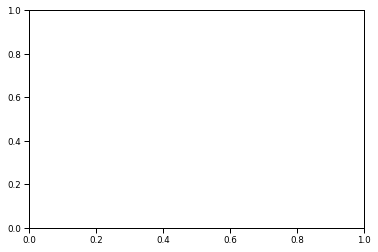

In [89]:
pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)
pool1 = pool1.filter_accuracies(X_test, y_test, 0.05)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score

print("Accuracies (F1): ", {c: f1_score(y_test, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(X_train).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(X_test).mean())

from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix


#classifiers = [pool1.models["SVMrbf"], pool1.models["XGB"]]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

    
#plot_roc_curve(pool1.models["SVMrbf"], X_test, y_test)
#plot_roc_curve(pool1.models["RF200"], X_test, y_test)

"""plot_confusion_matrix(classifiers[0], X_test, y_test, normalize='all')
plt.show()
plot_confusion_matrix(classifiers[1], X_test, y_test, normalize='all')
plt.show()
"""


In [90]:
%%time 

K_INIT = 1
MAX_EPOCHS = 5

#p2g = pool2graphBorders.pool2graph(X_train, y_train, pool1, k_init=10)
p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=K_INIT)
#p2gR = pool2graph_RandomSplit.pool2graph(X_train, y_train, pool1, k_init=K_INIT)

p2g.fit(max_epochs=MAX_EPOCHS)
#p2gR.fit(max_epochs=MAX_EPOCHS)
print(len(p2g.G.nodes))#, len(p2gR.G.nodes))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


6143
CPU times: user 13.8 s, sys: 2.93 s, total: 16.7 s
Wall time: 2.69 s


In [91]:
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))


2705


In [99]:

from discrepancies import analysis_global
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

Intervals amplitude dataset (self.amplitude_dataset): shape (2705, 96)
Input data preprocessed (self.X): shape (2010, 97)
Discrepancy nodes dataset (self.nodes_dataset): shape (1782, 96)
Nodes dataset (self.nodes_dataset): shape (6143, 97)


In [108]:
from sklearn.metrics import pairwise_distances_argmin

idx = 219

instance = X_test.iloc[idx, :]
instance[cat_names] = (instance[cat_names] > 0.0).astype("int")
from sklearn.metrics import pairwise_distances_argmin_min

idx_closest = pairwise_distances_argmin(instance.values.reshape(1, -1), gda.disc_nodes_dataset)
idx_closest = gda.disc_nodes_dataset.iloc[idx_closest].index
print((instance[cat_names] == gda.disc_nodes_dataset[cat_names].loc[idx_closest, :]).sum().sum())

##on tente ici de faire filtre categorielles
idx_closest, min_ = pairwise_distances_argmin_min(instance[cat_names].values.reshape(1, -1), gda.disc_nodes_dataset[cat_names])
print(idx_closest, min_)
idx_closest = gda.disc_nodes_dataset.iloc[idx_closest].index

for ci in intervals:
    if idx_closest in list(ci.border_features.index):
        interval_relevant = ci.border_features
        break

84
[186] [1.73205081]


0
capital-gain
0.0
1
capital-loss
0.0
2
age
-0.7263974112879139
3
education-num
-0.3848715240436934
4
hours-per-week
2.9826089406684924


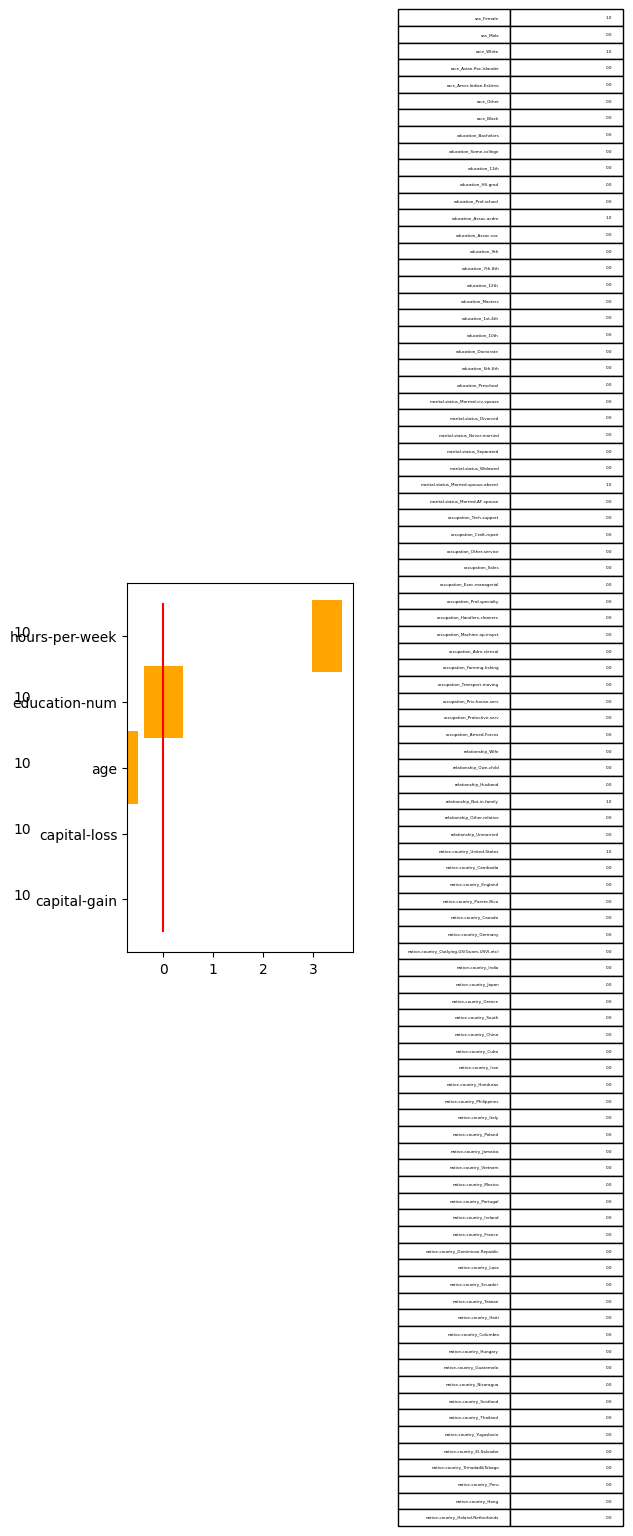

In [109]:
interval_to_plot = pd.DataFrame(scaler.inverse_transform(interval_relevant))
interval_to_plot.columns = X_train.columns
amplitude = pd.DataFrame(interval_to_plot.iloc[0, :] - interval_to_plot.iloc[1, :])
amplitude_normalized = interval_relevant.iloc[0, :] - interval_relevant.iloc[1, :]

interval_relevant2 = interval_relevant - instance

instance_orig_space = pd.DataFrame(scaler.inverse_transform(instance).reshape(1, -1))
instance_orig_space.columns = X_train.columns




fig, (ax1, ax2) = plt.subplots(1,2)
for i in range(len(cont_names)):
    print(i)
    print(cont_names[i])
    print(float(interval_relevant2.min()[cont_names[i]]))
    ax1.barh(y=i,left=float(interval_relevant2.min()[cont_names[i]]), height=1.1, width=float(amplitude_normalized[cont_names[i]]), color="orange")
    ax1.text(x=-3, y=i, s=10)
ax1.set_yticks(ticks=range(len(cont_names)))   
contlabels = cont_names
ax1.set_yticklabels(labels=contlabels)
ax1.vlines(x=0, ymin=-0.5, ymax = i+0.5, color='red')

ax2.table(np.array(list(zip(cat_names, instance[cat_names]))).reshape(-1, 2), loc="center", fontsize=100)
ax2.axis("off")
plt.show()

In [110]:
def normalize(x):
    return ((x-X_test[cont_names].min())/(X_test[cont_names].max()-X_test[cont_names].min()))

x = X_test.iloc[0]
k = 1

borders, train = get_discrepancy_intervals_from_x(p2g.G, x, k=k)
#fi = borders[1]
fi = {}
for interval in range(k):
    fi[interval] = borders[interval].iloc[1,:]
    fi[-(k+1)] = borders[interval].iloc[0,:]
fi = pd.DataFrame(fi).T

tmp = normalize(fi.max())

NameError: name 'get_discrepancy_intervals_from_x' is not defined

# Comparing dichotomic and random split

In [72]:
%%time 
from sklearn.metrics import pairwise_distances

N_SEGMENT = 10
K_INIT = [1]
EPOCHS = list(range(29))
N_ITERATION = 5

_alphas = list(np.random.random(N_SEGMENT))
#_alphas = np.tile(_alphas.reshape(N_SEGMENT, -1), (1, X_train.shape[1]))



out = {"precision": [], "k":[], "n_epochs":[], "algorithm":[], "n_generated":[], "n_iteration":[]}
for i in range(N_ITERATION):
    print(">>>>>>>>>>>>>>>>>> ITERATION", i)
    X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='breast-cancer', test_size=0.33, RANDOM_STATE=i)
    cont_names = list(set(feature_names) - set(cat_names))
    pool1 = pool.BasicPool()
    pool1 = pool1.fit(X_train, y_train)

    for k in K_INIT:
        print('============K', k)
        for epoch in EPOCHS:
            print('====EP', epoch)
            p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=k)
            p2gR = pool2graph_RandomSplit.pool2graph(X_train, y_train, pool1, k_init=k)
            
            
            if epoch <= 10:
                p2g.fit(max_epochs=epoch)
                intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
                dfU = pd.DataFrame(np.array([intervals[i].border_features.head(1) for i in range(len(intervals))]).reshape(-1, X_train.shape[1]))
                dfV = pd.DataFrame(np.array([intervals[i].border_features.tail(1) for i in range(len(intervals))]).reshape(-1, X_train.shape[1]))
            
            p2gR.fit(max_epochs=epoch)
            intervalsR = discrepancies_intervals.get_discrepancies_intervals(p2gR.G)
            dfUR = pd.DataFrame(np.array([intervalsR[i].border_features.head(1) for i in range(len(intervalsR))]).reshape(-1, X_train.shape[1]))
            dfVR = pd.DataFrame(np.array([intervalsR[i].border_features.tail(1) for i in range(len(intervalsR))]).reshape(-1, X_train.shape[1]))
            somme, sommeR = 0, 0
            for alpha in _alphas:
                if epoch <= 10:
                    newobs = alpha * dfU + (1 - alpha) * dfV
                    _preds = pool1.predict_discrepancies(newobs.values)
                    somme += _preds.mean()
                else:
                    somme += 0.99 * len(_alphas)

                newobsR = alpha * dfUR + (1 - alpha) * dfVR
                _predsR = pool1.predict_discrepancies(newobsR.values)
                sommeR += _predsR.mean()
            out["precision"].append(somme / len(_alphas))
            out["precision"].append(sommeR / len(_alphas))
            out["algorithm"].append('DIG')
            out["algorithm"].append('Random')
            out["n_generated"].append(len([n for n in p2g.G.nodes if n < 0]))
            out["n_generated"].append(len([n for n in p2gR.G.nodes if n < 0]))

            out["k"].append(k)
            out["n_epochs"].append(epoch)
            out["k"].append(k)
            out["n_epochs"].append(epoch)
            out["n_iteration"].append(i)
            out["n_iteration"].append(i)



>>>>>>>>>>>>>>>>>> ITERATION 0
[14:56:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
============K 1
====EP 0
====EP 1


INFO:root:### EPOCH #1
INFO:root:### EPOCH #1


====EP 2


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


====EP 3


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3


====EP 4


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


====EP 5


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


====EP 6


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6


====EP 7


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7


====EP 8


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8


====EP 9


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9


====EP 10


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10


====EP 11


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11


====EP 12


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12


====EP 13


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13


====EP 14


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14


====EP 15


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15


====EP 16


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16


====EP 17


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17


====EP 18


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18


====EP 19


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19


====EP 20


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20


====EP 21


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21


====EP 22


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22


====EP 23


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23


====EP 24


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24


====EP 25


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25


====EP 26


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26


====EP 27


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27


====EP 28


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27
INFO:root:### EPOCH #28


>>>>>>>>>>>>>>>>>> ITERATION 1
[14:59:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
============K 1
====EP 0
====EP 1


INFO:root:### EPOCH #1
INFO:root:### EPOCH #1


====EP 2


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


====EP 3


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3


====EP 4


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


====EP 5


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


====EP 6


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6


====EP 7


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7


====EP 8


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8


====EP 9


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9


====EP 10


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10


====EP 11


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11


====EP 12


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12


====EP 13


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13


====EP 14


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14


====EP 15


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15


====EP 16


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16


====EP 17


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17


====EP 18


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18


====EP 19


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19


====EP 20


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20


====EP 21


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21


====EP 22


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22


====EP 23


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23


====EP 24


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24


====EP 25


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25


====EP 26


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26


====EP 27


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27


====EP 28


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27
INFO:root:### EPOCH #28


>>>>>>>>>>>>>>>>>> ITERATION 2
[15:03:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
============K 1
====EP 0
====EP 1


INFO:root:### EPOCH #1
INFO:root:### EPOCH #1


====EP 2


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


====EP 3


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3


====EP 4


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


====EP 5


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


====EP 6


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6


====EP 7


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7


====EP 8


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8


====EP 9


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9


====EP 10


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10


====EP 11


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11


====EP 12


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12


====EP 13


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13


====EP 14


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14


====EP 15


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15


====EP 16


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16


====EP 17


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17


====EP 18


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18


====EP 19


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19


====EP 20


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20


====EP 21


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21


====EP 22


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22


====EP 23


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23


====EP 24


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24


====EP 25


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25


====EP 26


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26


====EP 27


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27


====EP 28


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27
INFO:root:### EPOCH #28


>>>>>>>>>>>>>>>>>> ITERATION 3
[15:07:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
============K 1
====EP 0
====EP 1


INFO:root:### EPOCH #1
INFO:root:### EPOCH #1


====EP 2


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


====EP 3


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3


====EP 4


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


====EP 5


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


====EP 6


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6


====EP 7


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7


====EP 8


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8


====EP 9


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9


====EP 10


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10


====EP 11


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11


====EP 12


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12


====EP 13


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13


====EP 14


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14


====EP 15


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15


====EP 16


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16


====EP 17


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17


====EP 18


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18


====EP 19


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19


====EP 20


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20


====EP 21


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21


====EP 22


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22


====EP 23


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23


====EP 24


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24


====EP 25


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25


====EP 26


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26


====EP 27


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27


====EP 28


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27
INFO:root:### EPOCH #28


>>>>>>>>>>>>>>>>>> ITERATION 4
[15:11:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
============K 1
====EP 0
====EP 1


INFO:root:### EPOCH #1
INFO:root:### EPOCH #1


====EP 2


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


====EP 3


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3


====EP 4


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


====EP 5


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


====EP 6


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6


====EP 7


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7


====EP 8


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8


====EP 9


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9


====EP 10


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10


====EP 11


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11


====EP 12


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12


====EP 13


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13


====EP 14


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14


====EP 15


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15


====EP 16


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16


====EP 17


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17


====EP 18


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18


====EP 19


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19


====EP 20


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20


====EP 21


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21


====EP 22


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22


====EP 23


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23


====EP 24


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24


====EP 25


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25


====EP 26


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26


====EP 27


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27


====EP 28


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9
INFO:root:### EPOCH #10
INFO:root:### EPOCH #11
INFO:root:### EPOCH #12
INFO:root:### EPOCH #13
INFO:root:### EPOCH #14
INFO:root:### EPOCH #15
INFO:root:### EPOCH #16
INFO:root:### EPOCH #17
INFO:root:### EPOCH #18
INFO:root:### EPOCH #19
INFO:root:### EPOCH #20
INFO:root:### EPOCH #21
INFO:root:### EPOCH #22
INFO:root:### EPOCH #23
INFO:root:### EPOCH #24
INFO:root:### EPOCH #25
INFO:root:### EPOCH #26
INFO:root:### EPOCH #27
INFO:root:### EPOCH #28


CPU times: user 2h 7min 17s, sys: 37min 24s, total: 2h 44min 42s
Wall time: 18min 30s


In [73]:
#IMPORTANT
dfout = pd.DataFrame(out)
dfout = dfout[~((dfout.algorithm=='DIG') & (dfout.n_epochs > 10))]

Text(0.5, 1.0, 'Breast Cancer dataset')

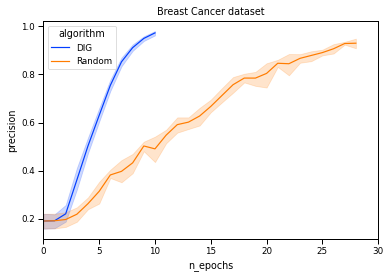

In [74]:
sns.lineplot(data=pd.DataFrame(dfout), x="n_epochs", y="precision", hue="algorithm", palette="bright",alpha=1)
sns.set_context("paper")
#plt.tight_layout()
plt.xlim((0.0, 30))
plt.title("Breast Cancer dataset")
#plt.savefig('../../results/precisionvsrandom_epochs_breastcancefr.pdf')

INFO:matplotlib.mathtext:Substituting symbol G from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol G from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol G from STIXNonUnicode


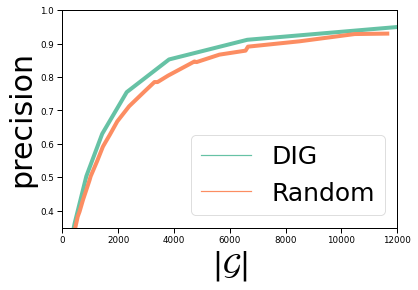

In [76]:
sns.set_context('paper')
dfout2 = dfout.copy()
#dfout2.n_generated = dfout2.n_generated.apply(np.log)
dfout2 = dfout2.groupby(['k', 'n_epochs', "algorithm"]).mean().reset_index()
sns.lineplot(data=dfout2, x="n_generated", y="precision", hue="algorithm", palette="Set2",alpha=1, linewidth=4)
#plt.tight_layout()
plt.ylim((0.35, 1.0))
plt.xlabel("$|\mathcal{G}|$", fontsize=30)
plt.ylabel("precision", fontsize=30)
plt.xlim((0.0, 12000))
plt.legend(fontsize=25)
#plt.title("Adult dataset", fontsize=20)
#plt.savefig('../../results/precisionvsrandom_budget_breastcancer.pdf')

In [47]:
dfout2

,precision,k,n_epochs,algorithm,n_generated,n_iteration
0,0.264187,1,0,DIG,0,0
1,0.264187,1,0,Random,0,0
2,0.267539,1,1,DIG,7,0
3,0.266028,1,1,Random,7,0
4,0.310626,1,2,DIG,86,0
...,...,...,...,...,...,...
281,0.903425,1,24,Random,6386,4
283,0.921136,1,25,Random,8356,4
285,0.916401,1,26,Random,7852,4
287,0.938073,1,27,Random,10408,4


In [ ]:
%%time
N_SEGMENT = 10

moyenne = 0
_alphas = np.random.random(N_SEGMENT)
_alphas = np.tile(_alphas.reshape(N_SEGMENT, -1), (1, X_train.shape[1]))

seui = 0.95
moyenne = 0
for ii in intervals:
    a0, a1 = ii.border_features.iloc[0], ii.border_features.iloc[1]
    new_obs = np.multiply(np.tile(a0, (N_SEGMENT, 1)), _alphas) + np.multiply(np.tile(a1, (N_SEGMENT, 1)), 1 - _alphas)
    _preds = pool1.predict_discrepancies(np.array(new_obs))
    moyenne += _preds.mean().mean()
print('P2G classique', moyenne / len(intervals))

moyenneR = 0
for ii in intervalsR:
    a0, a1 = ii.border_features.iloc[0], ii.border_features.iloc[1]
    new_obs = np.multiply(np.tile(a0, (N_SEGMENT, 1)), _alphas) + np.multiply(np.tile(a1, (N_SEGMENT, 1)), 1 - _alphas)
    _preds = pool1.predict_discrepancies(np.array(new_obs))
    moyenneR += _preds.mean().mean()
print('P2G classique', moyenneR / len(intervalsR))

In [ ]:
a0, a1 = intervals[1].border_features.iloc[0], intervals[1].border_features.iloc[1]
new_obs = np.multiply(np.tile(a0, (100, 1)), _alphas) + np.multiply(np.tile(a1, (100, 1)), 1 - _alphas)
_preds = pool1.predict_discrepancies(np.array(new_obs))

In [ ]:
intervals[1].border_features

In [ ]:
dff = pd.DataFrame(new_obs, columns=X_train.columns)
pool1.predict_discrepancies(dff).mean()

In [ ]:
%%time 
from sklearn.metrics import pairwise_distances


K_INIT = [1, 10, 100]
EPOCHS = [9]

#out = {} # décommenté si updater simplement dico

for k in K_INIT:
    print('====K', k)
    for epoch in EPOCHS:
        print('====EP', epoch)
        p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=k)

        p2g.fit(max_epochs=epoch)
        intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
        
        out[str(k)+"_"+str(epoch)] = []
        
        for ii in intervals:
            a, b = ii.border_features.iloc[0, :].values.reshape(1, -1), ii.border_features.iloc[1, :].values.reshape(1, -1)
            out[str(k)+"_"+str(epoch)].append(pairwise_distances(a, b)[0][0])
            ### --> pê inutile il y a p2g.G.edges.data() qui donne la distance des edges.


In [ ]:
BW = 0.2
ALPHA = 0.2
STAT = "probability" #"density"

sns.set_context('paper')

sns.histplot(out["1_2"], stat=STAT, color="blue", kde=False, element="step", alpha=ALPHA, binwidth=BW)
sns.histplot(out["1_5"], stat=STAT, color="cyan", kde=False, alpha=ALPHA, binwidth=BW, element="step")
#sns.distplot(out["1_9"])
sns.histplot(out["10_2"], stat=STAT, color="red", kde=False, element="step", alpha=ALPHA, binwidth=BW)
sns.histplot(out["10_5"], stat=STAT, color="pink", kde=False, element="step", alpha=ALPHA, binwidth=BW)
sns.histplot(out["100_2"], stat=STAT, color="green", kde=False, element="step", alpha=ALPHA, binwidth=BW)
sns.histplot(out["100_5"], stat=STAT, color="lime", kde=False, element="step", alpha=ALPHA, binwidth=BW)

plt.legend(labels=["$k=1, n_{epochs}=2$", "$k=1, n_{epochs}=5$", 
                   "$k=10, n_{epochs}=2$", "$k=10, n_{epochs}=5$",
                  "$k=100, n_{epochs}=2$", "$k=100, n_{epochs}=5$"], 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Boston dataset")
plt.tight_layout()
#plt.savefig('../../results/clamps_distance_boston.pdf')

In [ ]:
from scipy.stats import ttest_ind

print(ttest_ind(out["1_5"], out["10_5"], equal_var=False))

np.array(out["1_5"]).mean(), np.array(out["10_5"]).mean(), np.array(out["100_5"]).mean()

# Global analysis of the intervals

In [ ]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global

In [ ]:
### we work with that    
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

### Most problematic features

For now, we evaluate separately the uncertainty associated to each feature for continuous and categorical features.
- For continuous features: Average range of the discrepancy interval along the feature
- For categorical features: proportion of intervals generated along the feature, normalized by the exposition in Xtrain --> pas sûr qu'il faille normaliser par ça... car intercalle = 2 pts, X_train= chaque pt


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
#fname = '../../results/feature_importances_adult.pdf'
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')

In [ ]:
plt.figure(figsize=(len(feat_imp['continuous_features'])/2,4))
plt.xticks(rotation=70, fontsize=10)
sns.barplot(data=pd.DataFrame(feat_imp['continuous_features']).T, palette="mako")
#plt.title(" features")
plt.tight_layout()
#plt.savefig("./../../results/usecase_boston_featimp_cont.pdf")
plt.show()

In [ ]:
9, 3, 1
4.5, 3, 1
2.25, 1.5, 1
1.125, 0.75, 1
0.625, 0.5, 0.325

9, 3, 1
3, 1, 1
1, 0.33, 0.33



## Important areas of discrepancy

In [ ]:
%%time
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.05, min_purity=0.5, min_purity_expo=0.0)



In [ ]:
print("svm", f1_score(y_test, pool1.predict(X_test).iloc[:, 0]))
print("xgb", f1_score(y_test, pool1.predict(X_test).iloc[:, 1]))

def ensemble_segment(X, segments=[]):
    leaves = gda.segments_tree.apply(X)
    
    for leaf_index in segments:
        segments_index = np.where(leaves == leaf_index)
        
        
        

In [ ]:
%%time

LEAVES_SEGMENTS = (4,5)

data = gda.disc_nodes_dataset.sample(n=5000)
leaves_data = gda.segments_tree.apply(data)
leaves_data_rearr = np.array([ld if ld in LEAVES_SEGMENTS else -1 for ld in leaves_data])

colors = list(sns.color_palette("Set2", n_colors=len(set(leaves_data))))

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne['leaf'] = leaves_data_rearr
#tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.7)#, c=[colors[i] for i in leaves_data_rearr.values])
plt.title("t-SNE vizualisation of discrepancy nodes")
#plt.legend()
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

In [ ]:
self

In [ ]:
plt.savefig("./../../results/discussion_tsne_boston.pdf")

In [ ]:
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.1)#, c=[colors[i] for i in leaves_data_rearr.values])

In [ ]:
pool1.predict(X_test)



In [ ]:
pool1.predict_discrepancies(X_test).mean

# TODO
- Categorical: quand on génère les faux jumeaux, garder en mémoire les couples des modalités: blond-brun, et le changement associé?
- TSNE: couleurs 
- relative size: devrait être nombre de noeuds de discrepancy dans la feuille sur le nombre de noeuds de discrepancy